In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from CifFile import ReadCif

### Loading crystal data and finding the center of the pore

Let's load the information from the Crystallographic Information File (CIF) and see what's inside.

In [2]:
mcm41 = ReadCif('data/MCM-41/mcm-41.cif')

In [3]:
print(mcm41)

Writing CSD_CIF_MOLDRAW, <CifFile.StarFile.StarBlock object at 0x7f7f0b582fd0>
All blocks output.

##########################################################################
#               Crystallographic Information Format file
#               Produced by PyCifRW module
#
#  This is a CIF file.  CIF has been adopted by the International
#  Union of Crystallography as the standard for data archiving and
#  transmission.
#
#  For information on this file format, follow the CIF links at
#  http://www.iucr.org
##########################################################################

data_CSD_CIF_MOLDRAW

_audit_creation_date                    08-23-2013
_audit_creation_method                  MOLDRAW
_chemical_formula_sum                   'H102 O335 Si142'
_chemical_formula_moiety                
;
H102 O335 Si142
;
loop_
  _publ_author_name
         Piero     
         Ugliengo  
         Dip.      
         Chimica   
         University          
         of        
         Tori

In [4]:
label =       np.array(mcm41['csd_cif_moldraw']['_atom_site_label'])
type_symbol = np.array(mcm41['csd_cif_moldraw']['_atom_site_type_symbol'])
fract_x =     np.array(mcm41['csd_cif_moldraw']['_atom_site_fract_x'],dtype=float)
fract_y =     np.array(mcm41['csd_cif_moldraw']['_atom_site_fract_y'],dtype=float)
fract_z =     np.array(mcm41['csd_cif_moldraw']['_atom_site_fract_z'],dtype=float)
cell_length_a = float(mcm41['csd_cif_moldraw']['_cell_length_a'])
cell_length_b = float(mcm41['csd_cif_moldraw']['_cell_length_b'])
cell_length_c = float(mcm41['csd_cif_moldraw']['_cell_length_c'])
cell_angle_alpha = float(mcm41['csd_cif_moldraw']['_cell_angle_alpha'])*np.pi/180.0
cell_angle_beta = float(mcm41['csd_cif_moldraw']['_cell_angle_beta'])*np.pi/180.0
cell_angle_gamma = float(mcm41['csd_cif_moldraw']['_cell_angle_gamma'])*np.pi/180.0
pore_radius = 15.51 # see https://doi.org/10.1016/j.apsusc.2015.01.084

In [5]:
mcm_41xyz = np.genfromtxt('data/MCM-41/mcm-41.xyz',skip_header=2,dtype=[('type_symbol','|S2'),('x','f'),('y','f'),('z','f')])

In [6]:
ax1 = cell_length_a
ay1 = 0.0
ax2 = cell_length_b*np.cos(cell_angle_gamma)
ay2 = cell_length_b*np.sin(cell_angle_gamma)

In [7]:
np.save('mcm41UCdata',np.array([ax1,ax2,ay1,ay2]))

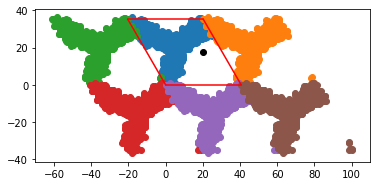

In [8]:
fig,ax = plt.subplots()
ax.scatter(mcm_41xyz['x'],mcm_41xyz['y'])
plt.plot([0,cell_length_a],[0,0],color='r')
plt.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
plt.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
plt.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.scatter(mcm_41xyz['x']+ax1,mcm_41xyz['y'])
ax.scatter(mcm_41xyz['x']-ax1,mcm_41xyz['y'])
ax.scatter(mcm_41xyz['x']-ax1-ax2,mcm_41xyz['y']-ay2)
ax.scatter(mcm_41xyz['x']-ax2,mcm_41xyz['y']-ay2)
ax.scatter(mcm_41xyz['x']+ax1-ax2,mcm_41xyz['y']-ay2)
ax.scatter([ax1/2],[ay2/2],color='k')
ax.set_aspect(1)

In [9]:
def putInBC(r,side,pSide = None):
    pSide = side if not pSide else pSide
    for i in range(len(r)):
        while r[i] >= 0.5 * side[i]:
            r[i] -= pSide[i]
        while r[i] < 0.5 * -side[i]:
            r[i] += pSide[i]
    return r

In [10]:
def putInBC2(r,side,pSide = None):
    pSide = side if not pSide else pSide
    s = r
    if (np.any(r >= (0.5 * side)) or np.any(r < -(0.5 * side))):
        s = (r + 2*side) % side
        s[s>=.5*side] -= side[s>=.5*side]
    return s

In [11]:
def putInBC3(r,side,pSide = None):
    pSide = side if not pSide else pSide
    ind = (r >= (0.5 * side)) + r < -(0.5 * side)
    s = r
    s[ind] = (r[ind] + 2*side[ind]) % side[ind]
    s[s>=.5*side] -= side[s>=.5*side]
    return s

In [12]:
testside = np.array([0.5,0.5])
%timeit putInBC((2.0*(np.random.random(2)-0.5)).tolist(),testside)
%timeit putInBC2((2.0*(np.random.random(2)-0.5)).tolist(),testside)
%timeit putInBC3((2.0*(np.random.random(2)-0.5)),testside)

5.18 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
25.5 µs ± 905 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
14.9 µs ± 197 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
testside = np.array([0.5,0.5])
%timeit putInBC((200.0*(np.random.random(2)-0.5)).tolist(),testside)
%timeit putInBC2((200.0*(np.random.random(2)-0.5)).tolist(),testside)
%timeit putInBC3((200.0*(np.random.random(2)-0.5)),testside)

84 µs ± 3.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24.1 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
14.9 µs ± 985 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
def total_distance_inv(r,r_cell,side,pSide = None):
    sep = []
    for s in (r_cell - r):
        sep.append(putInBC(s,side,pSide).tolist())
    return -np.sum(np.linalg.norm(np.array(sep),axis=1))

In [14]:
B = np.array([[1,np.cos(cell_angle_gamma)],[0,np.sin(cell_angle_gamma)]]) #transfer to Cartesian
A = np.linalg.inv(B) #transfer to unit cell coords

In [15]:
side = np.array([cell_length_a,cell_length_b])

In [16]:
# Cartesian to unit cell frame
test = np.dot(A,np.array([ax2,ay2]))

In [17]:
# Unit cell frame to Cartesian
test2 = np.dot(B,test)

In [18]:
print(test/side)
print(test2)
print(np.array([ax2,ay2]))

[8.74987136e-17 1.00000000e+00]
[-20.3015195   35.16326324]
[-20.3015195   35.16326324]


In [18]:
xy = np.array([mcm_41xyz['x'],mcm_41xyz['y']]).T

In [19]:
xy_uc = np.dot(A,xy.T).T-(side/2.0)

In [20]:
res = 100j
xy_test = np.mgrid[-side[0]/2.0:(side[0]/2.0):res,-side[1]/2.0:side[1]/2.0:res]

In [21]:
xy_test = np.reshape(xy_test,(2,int(abs(res*res)))).T

In [22]:
dist = []
for p in xy_test:
    dist.append(total_distance_inv(p,xy_uc,side))

In [23]:
xy_test[np.argmin(dist)]

array([  7.17730487, -10.45835853])

In [24]:
xytm = xy_test[np.argmin(dist)]
res = 100j
delta = 1.0
for i in range(15):
    delta=delta*0.1
    xy_test = np.mgrid[xytm[0]*(1.0-delta):xytm[0]*(1.0+delta):res,xytm[1]*(1.0-delta):xytm[1]*(1.0+delta):res]
    xy_test = np.reshape(xy_test,(2,int(abs(res*res)))).T
    dist = []
    for p in xy_test:
        dist.append(total_distance_inv(p,xy_uc,side))
    print(xy_test[np.argmin(dist)])

[  7.44554758 -10.21538656]
[  7.24907792 -10.35377494]
[  7.18448218 -10.44790017]
[  7.1780226  -10.45731269]
[  7.17737665 -10.45825395]
[  7.17731205 -10.45834807]
[  7.17730559 -10.45835748]
[  7.17730495 -10.45835843]
[  7.17730488 -10.45835852]
[  7.17730487 -10.45835853]
[  7.17730487 -10.45835853]
[  7.17730487 -10.45835853]
[  7.17730487 -10.45835853]
[  7.17730487 -10.45835853]
[  7.17730487 -10.45835853]


In [25]:
pore_center_mesh = np.dot(B,xy_test[np.argmin(dist)] + side/2.0)
print(pore_center_mesh)

[22.55724389  8.52442745]


In [26]:
pore_center_mesh_uc = xy_test[np.argmin(dist)]

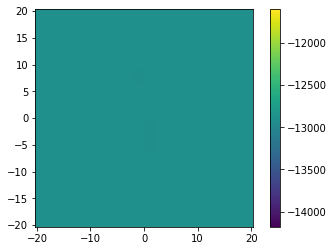

In [27]:
plt.imshow(np.reshape(dist,(100,100)).T,origin='lower',extent=(-side[0]/2.0,side[0]/2.0,-side[1]/2.0,side[1]/2.0))
plt.colorbar()

In [28]:
from scipy.optimize import minimize

In [29]:
#initial_guess = np.array([.75*side[0],.25*side[1]])-(side/2.0)
initial_guess = xy_test[np.argmin(dist)]

In [30]:
pore_center_uc = minimize(total_distance_inv,initial_guess,args=(xy_uc,side))

In [31]:
pore_center = np.dot(B,pore_center_uc.x)

In [32]:
pore_center_uc

      fun: -12891.668889216704
 hess_inv: array([[0.00588259, 0.00076242],
       [0.00076242, 0.00226157]])
      jac: array([0.14709473, 0.67919922])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 436
      nit: 9
     njev: 106
   status: 2
  success: False
        x: array([  7.44044827, -10.22583812])

In [33]:
total_distance_inv(xy_test[np.argmin(dist)],xy_uc,side)

-12890.45777678289

In [34]:
total_distance_inv(pore_center_uc.x,xy_uc,side)

-12891.668889216704

In [35]:
pore_center_uc.x

array([  7.44044827, -10.22583812])

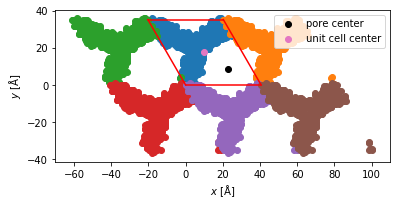

In [36]:
fig,ax = plt.subplots()
ax.scatter(mcm_41xyz['x'],mcm_41xyz['y'])
plt.plot([0,cell_length_a],[0,0],color='r')
plt.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
plt.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
plt.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.scatter(mcm_41xyz['x']+ax1,mcm_41xyz['y'])
ax.scatter(mcm_41xyz['x']-ax1,mcm_41xyz['y'])
ax.scatter(mcm_41xyz['x']-ax1-ax2,mcm_41xyz['y']-ay2)
ax.scatter(mcm_41xyz['x']-ax2,mcm_41xyz['y']-ay2)
ax.scatter(mcm_41xyz['x']+ax1-ax2,mcm_41xyz['y']-ay2)
ax.scatter(pore_center_mesh[0],pore_center_mesh[1],color='k',label=r'pore center')
ax.scatter(np.dot(B,side/2.0)[0],np.dot(B,side/2.0)[1],label=r'unit cell center')
ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
ax.set_aspect(1)
ax.legend(loc=1)
fig.savefig('plots/MCM-41-expanded-porecenter.svg',bbox_inches='tight')

In [37]:
xy_uc_shifted = []
for c in xy_uc-pore_center_mesh_uc:
    xy_uc_shifted.append(putInBC3(c,side))
xy_uc_shifted = np.array(xy_uc_shifted)

In [38]:
xy_uc_shifted

array([[ 18.97110478,   3.79011537],
       [ 18.27924581,  -0.24687662],
       [ 14.03550512,  -8.74204199],
       ...,
       [  0.88681349,  18.85827046],
       [ -1.54608215, -16.98433338],
       [  1.71794681, -15.38639212]])

In [39]:
mcm_41xyz_shifted = []
for c in xy_uc_shifted:
    mcm_41xyz_shifted.append(np.dot(B,c + side/2.0))
mcm_41xyz_shifted = np.array(mcm_41xyz_shifted)

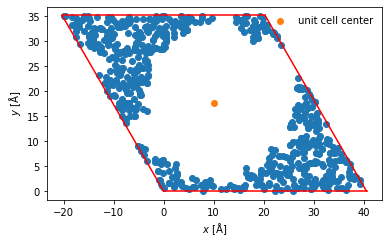

In [40]:
fig,ax = plt.subplots()
ax.scatter(mcm_41xyz_shifted[:,0],mcm_41xyz_shifted[:,1])
plt.plot([0,cell_length_a],[0,0],color='r')
plt.plot([0,cell_length_b*np.cos(cell_angle_gamma)],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
plt.plot([cell_length_b*np.cos(cell_angle_gamma),cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[cell_length_b*np.sin(cell_angle_gamma),cell_length_b*np.sin(cell_angle_gamma)],color='r')
plt.plot([cell_length_a,cell_length_b*np.cos(cell_angle_gamma)+cell_length_a],[0,cell_length_b*np.sin(cell_angle_gamma)],color='r')
ax.scatter(np.dot(B,side/2.0)[0],np.dot(B,side/2.0)[1],label=r'unit cell center')
ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
ax.set_aspect(1)
ax.legend(loc=1,frameon=False)
fig.savefig('plots/MCM-41-shifted.svg',bbox_inches='tight')

In [41]:
from scipy.special import ellipk, ellipe

def V(rho,sigma,n,R):
    pf = np.pi*n*(sigma**3)/3.0
    t9 = v9(rho/R)*((sigma/R)**9)
    t3 = v3(rho/R)*((sigma/R)**3)
    return pf*(t9-t3)

def Vshell(rho,sigma,n,R1,R2):
    pf = np.pi*n*(sigma**3)/3.0
    t9 = v9(rho/R1)*((sigma/R1)**9)
    t3 = v3(rho/R1)*((sigma/R1)**3)
    y9 = v9(rho/R2)*((sigma/R2)**9)
    y3 = v3(rho/R2)*((sigma/R2)**3)
    return pf*(y3-y9+t9-t3)

def v9(x):
    pf = 1.0/(240.0*((1.0-(x**2))**9))
    t1 = (1091.0 + (11156.0*(x**2)) + (16434.0*(x**4)) + (4052.0*(x**6)) + (35*(x**8)))*ellipe(x**2)
    t2 = 8.0 * (1.0-(x**2)) * (1.0 + (7.0*(x**2))) * (97.0 + (134.0*(x**2)) + (25.0*(x**4))) * ellipk(x**2)
    return pf*(t1-t2)

def v3(x):
    pf = 2.0/((1.0-(x**2))**3)
    t1 = (7.0 + (x**2)) * ellipe(x**2)
    t2 = 4.0 * (1.0-(x**2)) * ellipk(x**2)
    return pf*(t1-t2)

def U(r,sigma,epsilon):
    pf = 4.0 * epsilon
    t12 = (sigma/r)**12
    t6 = (sigma/r)**6
    return pf * (t12 - t6)
    

# Make arrays of atom positions based on thickness of substrate (from pore center out)

In [42]:
gridsize = 81
xarr = []
yarr = []
zarr = []
atomarr = []
for i in range(gridsize):
    ii = i - ((gridsize-1)/2)
    for j in range(gridsize):
        jj = j - ((gridsize-1)/2)
        xarr.append(mcm_41xyz['x'] + ii*ax1 + jj*ax2)
        yarr.append(mcm_41xyz['y'] + ii*ay1 + jj*ay2)
        zarr.append(mcm_41xyz['z'] - (cell_length_c/2.0))
        atomarr.append(mcm_41xyz['type_symbol'])

In [43]:
points = np.rec.fromarrays((np.reshape(xarr,np.prod(np.shape(xarr))),
                            np.reshape(yarr,np.prod(np.shape(yarr))),
                            np.reshape(zarr,np.prod(np.shape(zarr))),
                            np.reshape(atomarr,np.prod(np.shape(atomarr)))), names=('x', 'y', 'z', 'atom'))
print(points['x'][0])
points['x'] -= pore_center_mesh[0]
points['y'] -= pore_center_mesh[1]
print(points['x'][0])

-813.0305
-835.58777


In [44]:
r = np.sqrt((points['x']**2) + (points['y']**2))

In [45]:
points = points[np.argsort(r)]
r = np.sort(r)

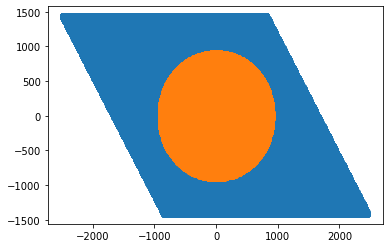

In [46]:
plt.scatter(points['x'],points['y'])
r_cut=900.0
plt.scatter(points['x'][r<r_cut],points['y'][r<r_cut])

### Now we can try to scale $r_\mathrm{cut}$ until the difference in the manybody potentials is below float

#### Will scale for two cases, $r_\mathrm{He}=0.0$ and $r_\mathrm{He}=15.51$

In [47]:
# sigma and epsilon parameters for atoms in silica and helium
# See https://doi.org/10.1016/j.apsusc.2015.01.084 and https://doi.org/10.1016/S0927-7757(01)00628-8
sigmaarr = np.array([(3.804,3.033,2.846,2.640,3.405,2.782)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])
epsilonarr = np.array([(155.858,48.115,0.0503,10.9,119.8,37.29134539)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])

# functions to mix the LJ parameters
# See https://doi.org/10.1016/S0927-7757(01)00628-8
def mixsigma(s1,s2):
    return (s1+s2)/2.0

def mixepsilon(e1,e2):
    return (e1*e2)**0.5

In [48]:
sarr = np.zeros_like(points['x'])
earr = np.zeros_like(points['x'])
for n in sigmaarr.dtype.names:
    n_byte = str.encode(n)
    sarr[points['atom']==n_byte] = mixsigma(sigmaarr[n],sigmaarr['He'])
    earr[points['atom']==n_byte] = mixepsilon(epsilonarr[n],epsilonarr['He'])

#### Case 1: $r_\mathrm{He}=0.0$

In [49]:
def U_mb(r,points,sigma,epsilon):
    sep = np.sqrt(((points['x']-r[0])**2) + ((points['y']-r[1])**2) + ((points['z']-r[2])**2))
    return np.sum(U(sep,sigma,epsilon))

In [50]:
def U_mb2(sep,sigma,epsilon):
    return np.sum(U(sep,sigma,epsilon),1)

In [51]:
x = np.linspace(0,17,1000)
y = np.zeros_like(x)

In [52]:
r_cut=500.0
cutpoints = points[r < r_cut]
cutsigma = sarr[r < r_cut]
cutepsilon = earr[r < r_cut]

In [53]:
from scipy.spatial.distance import cdist
sep = cdist(np.vstack((x,y,y)).T, np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T, 'euclidean')

In [54]:
V_test = U_mb2(sep,cutsigma,cutepsilon)

Text(0, 0.5, '$U_\\mathrm{mb}(r)$ $\\mathrm{[K]}$')

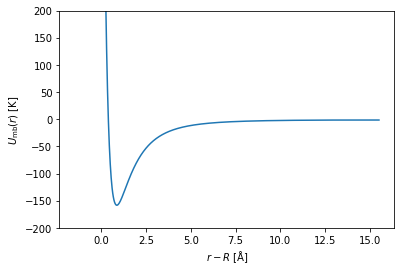

In [55]:
plt.plot(pore_radius - x,V_test)
plt.ylim(-200,200)
#plt.xlim(1.0,pore_radius)
plt.xlabel(r'$r-R$ $\mathrm{[\AA]}$')
plt.ylabel(r'$U_\mathrm{mb}(r)$ $\mathrm{[K]}$')

In [57]:
r_cut=500
cutpoints = points[r < r_cut]
cutsigma = sarr[r < r_cut]
cutepsilon = earr[r < r_cut]
V_cut = []
for r_test in np.vstack((x,y,y)).T:
    V_cut.append(U_mb(r_test,cutpoints,cutsigma,cutepsilon))

In [58]:
sep = cdist(np.vstack((x,y,y)).T, np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T, 'euclidean')

In [59]:
V_cut = U_mb2(sep,cutsigma,cutepsilon)

In [60]:
V_cut = np.array(V_cut)
V_test = np.array(V_test)

Text(0, 0.5, '$U_\\mathrm{mb}(r)$ $\\mathrm{[K]}$')

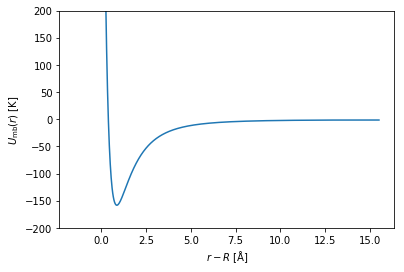

In [61]:
plt.plot(pore_radius - x,V_cut)
plt.ylim(-200,200)
#plt.xlim(1.0,pore_radius)
plt.xlabel(r'$r-R$ $\mathrm{[\AA]}$')
plt.ylabel(r'$U_\mathrm{mb}(r)$ $\mathrm{[K]}$')

Text(0, 0.5, '$U_\\mathrm{mb}(r)$ $\\mathrm{[K]}$')

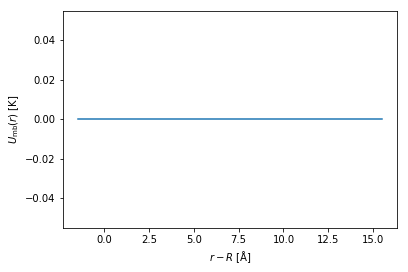

In [62]:
plt.plot(pore_radius - x,np.abs((V_test-V_cut)/V_test))
#plt.ylim(-200,200)
#plt.xlim(1.0,pore_radius)
plt.xlabel(r'$r-R$ $\mathrm{[\AA]}$')
plt.ylabel(r'$U_\mathrm{mb}(r)$ $\mathrm{[K]}$')

In [ ]:
import datetime
import time

V_z = np.copy(V_test)
V_zcut = np.copy(V_test)
t1 = np.array(V_z,dtype=np.float32)
t2 = np.array(V_zcut,dtype=np.float32)

numzsteps = 150
timearr=[]
for i in range(numzsteps):
    timeold = time.time()
    sep = cdist(np.vstack((x,y,y+((i+1)*cell_length_c))).T, np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T, 'euclidean')
    V_zcut+=U_mb2(sep,cutsigma,cutepsilon)
    sep = cdist(np.vstack((x,y,y-((i+1)*cell_length_c))).T, np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T, 'euclidean')
    V_zcut+=U_mb2(sep,cutsigma,cutepsilon)
    t1 = np.copy(t2)
    t2 = np.array(V_zcut,dtype=np.float32)
    percentEqual = 100*np.sum(t1==t2)/len(t1)
    percentComplete = 100*i/numzsteps
    timenew = time.time()
    timearr.append(timenew-timeold)
    timeleft = str(datetime.timedelta(seconds=np.average(timearr)*(numzsteps-i)))
    print('Step {} of {}. Estimated time remaining = {} : {:.5f}% complete : {:.3f}% equal'.format(i, numzsteps, timeleft, percentComplete, percentEqual), end='\r')
    if np.all(t1==t2):
        timeleft = str(datetime.timedelta(seconds=0))
        print('Step {} of {}. Estimated time remaining = {} : {:.5f}% complete : {:.3f}% equal'.format(i, numzsteps, timeleft, 100, 100))
        break

In [ ]:
import datetime
import time

V_z = np.copy(V_test)
V_zcut = np.copy(V_test)
t1 = np.array(V_z,dtype=np.float32)
t2 = np.array(V_zcut,dtype=np.float32)

numzsteps = 150
timearr=[]
for i in range(numzsteps):
    timeold = time.time()
    sep = cdist(np.vstack((x,y,y+((i+1)*cell_length_c))).T, np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T, 'euclidean')
    V_zcut+=U_mb2(sep,cutsigma,cutepsilon)
    sep = cdist(np.vstack((x,y,y-((i+1)*cell_length_c))).T, np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T, 'euclidean')
    V_zcut+=U_mb2(sep,cutsigma,cutepsilon)
    t1 = np.copy(t2)
    t2 = np.array(V_zcut,dtype=np.float32)
    percentEqual = 100*np.sum(t1==t2)/len(t1)
    percentComplete = 100*i/numzsteps
    timenew = time.time()
    timearr.append(timenew-timeold)
    timeleft = str(datetime.timedelta(seconds=np.average(timearr)*(numzsteps-i)))
    print('Step {} of {}. Estimated time remaining = {} : {:.5f}% complete : {:.3f}% equal'.format(i, numzsteps, timeleft, percentComplete, percentEqual), end='\r')
    if np.all(t1==t2):
        timeleft = str(datetime.timedelta(seconds=0))
        print('Step {} of {}. Estimated time remaining = {} : {:.5f}% complete : {:.3f}% equal'.format(i, numzsteps, timeleft, 100, 100))
        break

In [85]:
len(np.vstack((x,y,y+((i+1)*cell_length_c))).T)

1000

In [107]:
ztestpoints = np.array([np.hstack((x,x)*150),np.hstack((y,y)*150),np.reshape([np.hstack((np.ones_like(x)*(i+1)*cell_length_c,-np.ones_like(x)*(i+1)*cell_length_c)) for i in range(150)],numzsteps*len(x)*2)]).T

In [126]:
sep = cdist(ztestpoints[0:5000], np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T, 'euclidean')

In [127]:
V_ztest = U_mb2(sep,cutsigma,cutepsilon)

Text(0,0.5,'$U_\\mathrm{mb}(r)$ $\\mathrm{[K]}$')

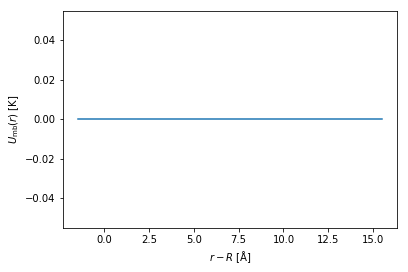

In [142]:
plt.plot(pore_radius - x,np.abs((t1-t2)/t1))
#plt.ylim(-200,200)
#plt.xlim(1.0,pore_radius)
plt.xlabel(r'$r-R$ $\mathrm{[\AA]}$')
plt.ylabel(r'$U_\mathrm{mb}(r)$ $\mathrm{[K]}$')

Text(0,0.5,'$U_\\mathrm{mb}(r)$ $\\mathrm{[K]}$')

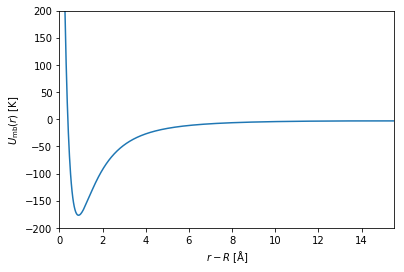

In [148]:
plt.plot(pore_radius - x,V_zcut)
plt.ylim(-200,200)
plt.xlim(0,pore_radius)
plt.xlabel(r'$r-R$ $\mathrm{[\AA]}$')
plt.ylabel(r'$U_\mathrm{mb}(r)$ $\mathrm{[K]}$')

np.savetxt('data/MCM-41/mcm-41-effectiveU.dat',V_zcut)

In [12]:
def U_min(r,sigma,n,R):
    pore_radius = 15.51 # see https://doi.org/10.1016/j.apsusc.2015.01.084
    return V(r,sigma,n,R)

In [401]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(np.vstack((x,y,y)).T,axis=-1)
ydata = np.array(V_zcut)

In [402]:
fitind = (xdata < pore_radius) * (ydata < 0.0)

In [403]:
popt, pcov = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.321375968414343, 5.211800749771209,16])

In [404]:
perr = np.sqrt(np.diag(pcov))

In [405]:
print(perr)

[0.00676241 0.0209824  0.00516049]


In [406]:
popt

array([ 3.03085144,  2.53371415, 17.26393808])

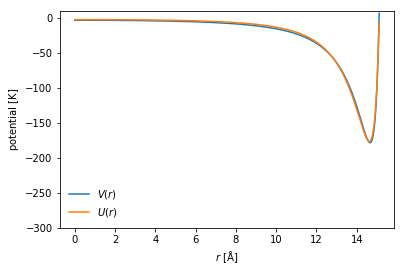

In [408]:
plt.plot(xdata[fitind],U_min(xdata[fitind],popt[0],popt[1],popt[2]),label=r'$V(r)$')
#plt.plot(xdata[fitind],U_min(xdata[fitind],2.6, 4.1,16.8),label=r'$V(r)$')
plt.plot(xdata[fitind],ydata[fitind],label=r'$U(r)$')
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'potential $\mathrm{[K]}$')
plt.legend(frameon=False)
plt.ylim(-300,10)
plt.savefig('effectivePotential.svg',bbox_inches='tight')

### Radially averaged data

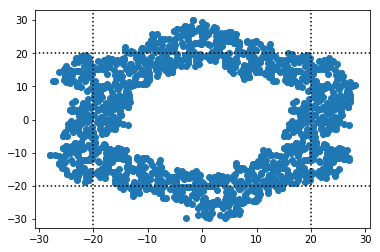

In [411]:
r_cut=30.0
plt.scatter(points['x'][r<r_cut],points['y'][r<r_cut])
plt.axhline(-20,-20,20,linestyle=':',color='k')
plt.axhline(20,-20,20,linestyle=':',color='k')
plt.axvline(-20,-20,20,linestyle=':',color='k')
plt.axvline(20,-20,20,linestyle=':',color='k')

In [194]:
res = 100j
meshsize = int(abs(res*res))
rxmesh,rymesh = np.mgrid[-20:20:res,-20:20:res]
rzmesh = np.zeros_like(rxmesh)
rmeshpoints = np.vstack((np.reshape(rxmesh,meshsize),np.reshape(rymesh,meshsize),np.reshape(rzmesh,meshsize))).T

In [196]:
rmesha = np.argsort(np.linalg.norm(rmeshpoints,axis=-1))
rmeshaa = np.argsort(rmesha)

In [197]:
rmeshpoints = rmeshpoints[rmesha]

In [133]:
stackedcutpoints = np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T

In [157]:
Vmesh = np.zeros_like(rmeshpoints[:,0])

In [147]:
np.shape(Vmesh)

(10000,)

In [ ]:
((i+1)*cell_length_c)

In [158]:
timeold = time.time()
Vmesh[0:len(rmeshpoints)//2]+=U_mb2(cdist(rmeshpoints[0:len(rmeshpoints)//2], stackedcutpoints, 'euclidean'),cutsigma,cutepsilon)
Vmesh[len(rmeshpoints)//2:len(rmeshpoints)]+=U_mb2(cdist(rmeshpoints[len(rmeshpoints)//2:len(rmeshpoints)], stackedcutpoints, 'euclidean'),cutsigma,cutepsilon)
timenew = time.time()

In [159]:
print(timenew-timeold)

614.893666267395


In [193]:
np.arange(6)[np.argsort([3,5,2,1,4,0])]

array([5, 3, 2, 0, 4, 1])

In [ ]:
import datetime
import time

t1 = np.array(Vmesh,dtype=np.float32)
t2 = np.array(Vmesh,dtype=np.float32)

numzsteps = 150
timearr=[]
for i in range(numzsteps):
    timeold = time.time()
    Vmesh[0:len(rmeshpoints)//2]+=U_mb2(cdist(rmeshpoints[0:len(rmeshpoints)//2], stackedcutpoints + [0.0,0.0,((i+1)*cell_length_c)], 'euclidean'),cutsigma,cutepsilon)
    Vmesh[len(rmeshpoints)//2:len(rmeshpoints)]+=U_mb2(cdist(rmeshpoints[len(rmeshpoints)//2:len(rmeshpoints)], stackedcutpoints + [0.0,0.0,((i+1)*cell_length_c)], 'euclidean'),cutsigma,cutepsilon)
    Vmesh[0:len(rmeshpoints)//2]+=U_mb2(cdist(rmeshpoints[0:len(rmeshpoints)//2], stackedcutpoints + [0.0,0.0,-((i+1)*cell_length_c)], 'euclidean'),cutsigma,cutepsilon)
    Vmesh[len(rmeshpoints)//2:len(rmeshpoints)]+=U_mb2(cdist(rmeshpoints[len(rmeshpoints)//2:len(rmeshpoints)], stackedcutpoints + [0.0,0.0,-((i+1)*cell_length_c)], 'euclidean'),cutsigma,cutepsilon)
    t1 = np.copy(t2)
    t2 = np.array(Vmesh,dtype=np.float32)
    percentEqual = 100*np.sum(t1==t2)/len(t1)
    percentComplete = 100*i/numzsteps
    timenew = time.time()
    timearr.append(timenew-timeold)
    timeleft = str(datetime.timedelta(seconds=np.average(timearr)*(numzsteps-i)))
    print('Step {} of {}. Estimated time remaining = {} : {:.5f}% complete : {:.3f}% equal'.format(i, numzsteps, timeleft, percentComplete, percentEqual), end='\r')
    if np.all(t1==t2):
        timeleft = str(datetime.timedelta(seconds=0))
        print('Step {} of {}. Estimated time remaining = {} : {:.5f}% complete : {:.3f}% equal'.format(i, numzsteps, timeleft, 100, 100))
        break

In [ ]:
np.save()

In [172]:
rmesh = np.sqrt((rmeshpoints[:,0]**2)+(rmeshpoints[:,1]**2))
rind = np.argsort(rmesh)

(-600, 200)

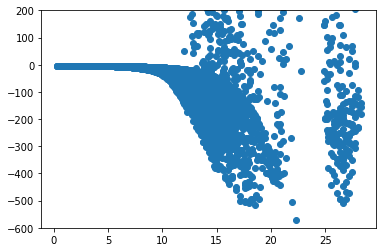

In [198]:
plt.scatter(rmesh[rmeshaa],Vmesh[rmeshaa])
plt.ylim(-600,200)

In [210]:
(rmeshpoints[np.argmin(Vmesh)] + [20,20,0])/(40/100)

array([ 6.06060606, 83.83838384,  0.        ])

In [213]:
VmeshUnsorted = np.reshape(Vmesh[rmeshaa],(int(abs(res)),int(abs(res))))

In [ ]:
np.save("VmeshUnsorted.npy",VmeshUnsorted)

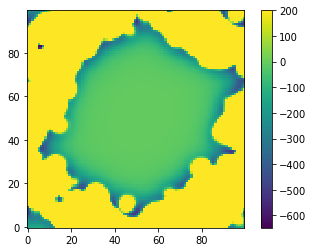

In [214]:
plt.imshow(VmeshUnsorted.T,origin='lower',vmax=200)
plt.colorbar()
#plt.scatter([6],[84],color='k')

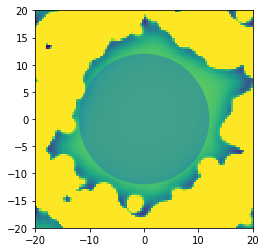

In [240]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
ax.imshow(VmeshUnsorted.T,origin='lower',vmax=200,extent=(-20,20,-20,20))
circ = Circle((0,0),12,alpha=.5)
ax.add_patch(circ)

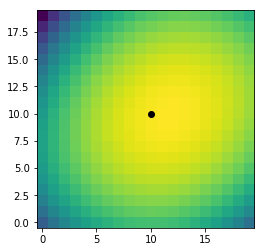

In [218]:
plt.imshow(VmeshUnsorted[40:60,40:60].T,origin='lower')
#plt.colorbar()
plt.scatter([10],[10],color='k')

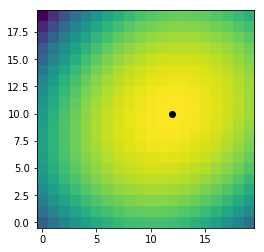

In [229]:
plt.imshow(VmeshUnsorted[40:60,40:60].T,origin='lower')
#plt.colorbar()
plt.scatter([12],[10],color='k')

In [234]:
.1*40/20

0.2

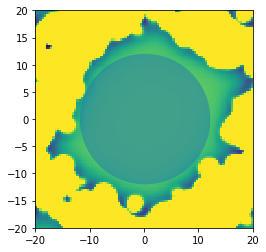

In [273]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
ax.imshow(VmeshUnsorted.T,origin='lower',vmax=200,extent=(-20,20,-20,20))
circ = Circle((.2,0),12,alpha=.5)
ax.add_patch(circ)

(-150, 10)

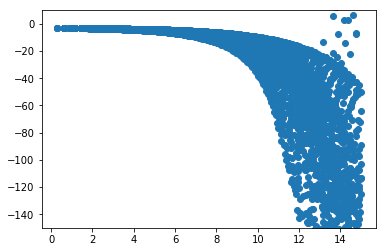

In [256]:
plt.scatter(rmesh[rmesh<15],Vmesh[rmesh<15])
plt.ylim(-150,10)

In [254]:
len(rmesh[rmesh<rcut])

4344

In [276]:
from scipy.optimize import curve_fit
rcut = 16
xdata2 = rmesh[rmesh<rcut]
ydata2 = Vmesh[rmesh<rcut]

fitind = (ydata2 < 0.0)

popt, pcov = curve_fit(U_min, xdata2[fitind], ydata2[fitind],[2.321375968414343, 5.211800749771209,16],maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[9.38327694e-01 9.68269968e-07 8.24268189e-01]
[ 5.14309486e+01 -9.97256429e-06  4.22627584e+01]


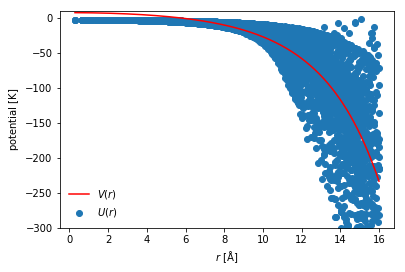

In [277]:
plt.scatter(xdata2[fitind],ydata2[fitind],label=r'$U(r)$')
plt.plot(xdata2[fitind],U_min(xdata2[fitind],popt[0],popt[1],popt[2]),label=r'$V(r)$',color='r')
#plt.plot(xdata[fitind],U_min(xdata[fitind],2.6, 4.1,16.8),label=r'$V(r)$')
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'potential $\mathrm{[K]}$')
plt.legend(frameon=False)
plt.ylim(-300,10)
plt.savefig('effectivePotential2.svg',bbox_inches='tight')

In [280]:
from scipy.optimize import curve_fit
rcut = pore_radius
xdata2 = rmesh[rmesh<rcut]
ydata2 = Vmesh[rmesh<rcut]

fitind = (ydata2 < 0.0)

popt, pcov = curve_fit(U_min, xdata2[fitind], ydata2[fitind],[2.321375968414343, 5.211800749771209,16])

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[0.06730961 0.05989125 0.06467252]
[ 4.17069556  1.01764773 18.7265926 ]


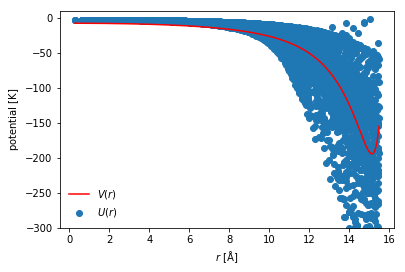

In [281]:
plt.scatter(xdata2[fitind],ydata2[fitind],label=r'$U(r)$')
plt.plot(xdata2[fitind],U_min(xdata2[fitind],popt[0],popt[1],popt[2]),label=r'$V(r)$',color='r')
#plt.plot(xdata[fitind],U_min(xdata[fitind],2.6, 4.1,16.8),label=r'$V(r)$')
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'potential $\mathrm{[K]}$')
plt.legend(frameon=False)
plt.ylim(-300,10)
plt.savefig('effectivePotential2.svg',bbox_inches='tight')

In [405]:
def U_min2(r,sigma,n):
    pore_radius = 15.51 # see https://doi.org/10.1016/j.apsusc.2015.01.084
    return V(r,sigma,n,pore_radius)

In [445]:
from scipy.optimize import curve_fit
rcut = pore_radius
xdata2 = rmesh[rmesh<rcut]
ydata2 = Vmesh[rmesh<rcut]

fitind = (ydata2 < 0.0)

popt, pcov = curve_fit(U_min2, xdata2[fitind], ydata2[fitind],[1.5,50],bounds=([0,0],[np.infty,np.infty]))

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[  308171.18946814 38942773.38844284]
[0.01159939 0.23642429]


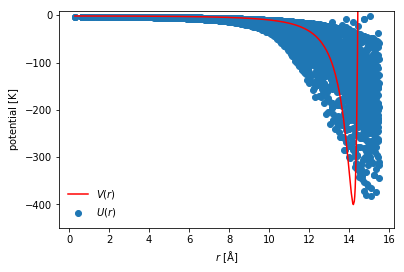

In [444]:
plt.scatter(xdata2[fitind],ydata2[fitind],label=r'$U(r)$')
plt.plot(xdata2[fitind],U_min2(xdata2[fitind],1.5,50),label=r'$V(r)$',color='r')
#plt.plot(xdata[fitind],U_min(xdata[fitind],2.6, 4.1,16.8),label=r'$V(r)$')
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'potential $\mathrm{[K]}$')
plt.legend(frameon=False)
plt.ylim(-450,10)
plt.savefig('effectivePotential2.svg',bbox_inches='tight')

In [446]:
rcut=pore_radius
uniquer = []
Vavg = []
for c in np.unique(rmesh[rmesh<rcut]):
    uniquer.append(c)
    Vavg.append(np.average(Vmesh[rmesh<rcut][np.where(rmesh[rmesh<rcut]==c)]))

(-150, 10)

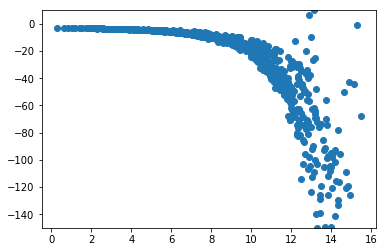

In [448]:
plt.scatter(uniquer,Vavg)
plt.ylim(-150,10)

In [472]:
from scipy.optimize import curve_fit
rcut = 15
xdata2 = rmesh[rmesh<rcut]
ydata2 = Vmesh[rmesh<rcut]

fitind = (ydata2 < 0.0)

popt, pcov = curve_fit(U_min2, xdata2[fitind], ydata2[fitind],[2.05471856, 7.05456898],bounds=([0,0],[10,400]))

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)

[2.81663499e-03 8.06566362e+00]
[  0.71926631 344.89396683]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


(-200, 10)

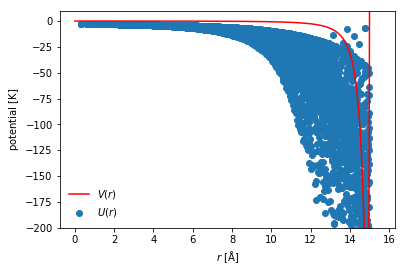

In [473]:
plt.scatter(xdata2[fitind],ydata2[fitind],label=r'$U(r)$')
plt.plot(np.linspace(0,pore_radius,1000),U_min2(np.linspace(0,pore_radius,1000),popt[0],popt[1]),label=r'$V(r)$',color='r')
#plt.plot(xdata[fitind],U_min(xdata[fitind],2.6, 4.1,16.8),label=r'$V(r)$')
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'potential $\mathrm{[K]}$')
plt.legend(frameon=False)
plt.ylim(-200,10)
#plt.savefig('effectivePotential2.svg',bbox_inches='tight')

In [516]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [521]:
rhomesh,phimesh=cart2pol(rmeshpoints[:,0],rmeshpoints[:,1])

In [522]:
rhomesh = rhomesh[np.argsort(phimesh)]
Vmesh_pol = Vmesh[np.argsort(phimesh)]
phimesh=np.sort(phimesh)+np.pi

In [554]:
rhoarr=[]
phiarr=[]
varr=[]

angle = np.arange(0,365,5)*np.pi/180
for i,a in enumerate(angle[0:-1]):
    phiind = (phimesh>=a)*(phimesh<angle[i+1])
    rhotmp = rhomesh[phiind]
    rhoind = np.argsort(rhotmp)
    rhoarr.append(rhomesh[phiind][rhoind])
    phiarr.append(phimesh[phiind][rhoind])
    varr.append(Vmesh_pol[phiind][rhoind])

In [555]:
test = np.array([len(c) for c in rhoarr])

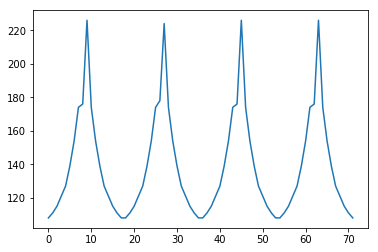

In [556]:
plt.plot(test)

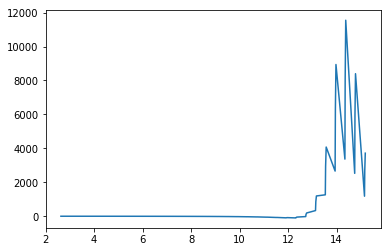

In [563]:
rcut = pore_radius
i = 0
c = rhoarr[i]
cind = c < rcut
plt.plot(c[cind],varr[i][cind])

(-300, 10)

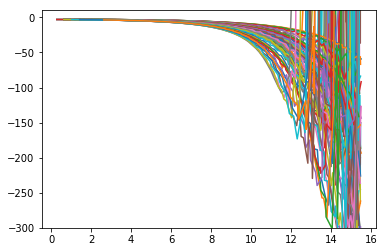

In [565]:
rcut = pore_radius
for i, c in enumerate(rhoarr):
    cind = c < rcut
    plt.plot(c[cind],varr[i][cind])
plt.ylim(-300,10)

In [733]:
rcut = pore_radius
fitparams = []
fiterr = []
for i, c in enumerate(rhoarr):
    cind = c < rcut
    xdata = c[cind]
    ydata = varr[i][cind]

    fitind = (ydata < 0.0)

    popt, pcov = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.321375968414343, 5.211800749771209,16],maxfev=10000)

    perr = np.sqrt(np.diag(pcov))
    fitparams.append(popt)
    fiterr.append(perr)
fitparams=np.array(fitparams)
fiterr=np.array(fiterr)

72
70
69
66
62
61


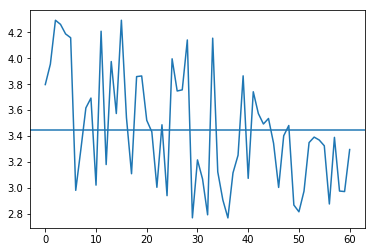

In [734]:
fitSigma = fitparams[:,0]
avgSigma = np.average(fitSigma)
errSigma = np.std(fitSigma)
minSigma = fitSigma >= (avgSigma - (2*errSigma))
maxSigma = fitSigma <= (avgSigma + (2*errSigma))
indSigma = minSigma*maxSigma
newAvgSigma = np.average(fitSigma[indSigma])
print(len(fitSigma))
while True:  
    print(len(fitSigma[indSigma]))
    avgSigma = newAvgSigma
    errSigma = np.std(fitSigma[indSigma])
    minSigma = fitSigma >= (avgSigma - (2*errSigma))
    maxSigma = fitSigma <= (avgSigma + (2*errSigma))
    indSigma = minSigma*maxSigma
    newAvgSigma = np.average(fitSigma[indSigma])
    if newAvgSigma == avgSigma:
        break
errSigma=errSigma/np.sqrt(len(fitSigma[indSigma]))
plt.plot(fitSigma[indSigma])
plt.axhline(avgSigma)

72
71
67
63
61


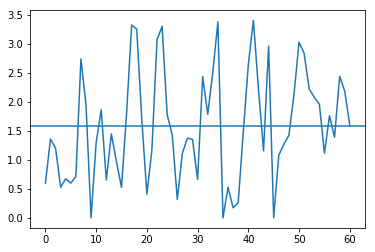

In [735]:
fitnEpsilon = fitparams[:,1]
avgnEpsilon = np.average(fitnEpsilon)
errnEpsilon = np.std(fitnEpsilon)
minnEpsilon = fitnEpsilon >= (avgnEpsilon - (2*errnEpsilon))
maxnEpsilon = fitnEpsilon <= (avgnEpsilon + (2*errnEpsilon))
indnEpsilon = minnEpsilon*maxnEpsilon
newAvgnEpsilon = np.average(fitnEpsilon[indnEpsilon])
print(len(fitnEpsilon))
while True:  
    print(len(fitnEpsilon[indnEpsilon]))
    avgnEpsilon = newAvgnEpsilon
    errnEpsilon = np.std(fitnEpsilon[indnEpsilon])
    minnEpsilon = fitnEpsilon >= (avgnEpsilon - (2*errnEpsilon))
    maxnEpsilon = fitnEpsilon <= (avgnEpsilon + (2*errnEpsilon))
    indnEpsilon = minnEpsilon*maxnEpsilon
    newAvgnEpsilon = np.average(fitnEpsilon[indnEpsilon])
    if newAvgnEpsilon == avgnEpsilon:
        break
errnEpsilon=errnEpsilon/np.sqrt(len(fitnEpsilon[indnEpsilon]))
plt.plot(fitnEpsilon[indnEpsilon])
plt.axhline(avgnEpsilon)

72
69
66
61
58
55
50
46
44
42
41


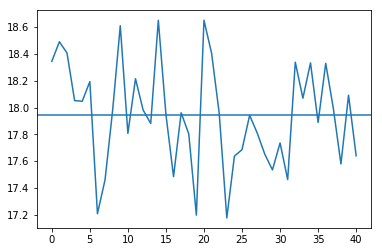

In [736]:
fitR = fitparams[:,2]
avgR = np.average(fitR)
errR = np.std(fitR)
minR = fitR >= (avgR - (2*errR))
maxR = fitR <= (avgR + (2*errR))
indR = minR*maxR
newAvgR = np.average(fitR[indR])
print(len(fitR))
while True:  
    print(len(fitR[indR]))
    avgR = newAvgR
    errR = np.std(fitR[indR])
    minR = fitR >= (avgR - (2*errR))
    maxR = fitR <= (avgR + (2*errR))
    indR = minR*maxR
    newAvgR = np.average(fitR[indR])
    if newAvgR == avgR:
        break
errR=errR/np.sqrt(len(fitR[indR]))
plt.plot(fitR[indR])
plt.axhline(avgR)

In [737]:
errSigma

0.05669682360088373

In [738]:
errnEpsilon

0.1216576291027185

In [739]:
errR

0.06023721172749187

In [740]:
print('$\sigma={:.3f}\mathrm{{Å}}$, $n\epsilon = {:.3f}\mathrm{{KÅ^{{-2}}}}$, and $R={:.3f}\mathrm{{Å}}$'.format(avgSigma,avgnEpsilon,avgR))

$\sigma=3.445\mathrm{Å}$, $n\epsilon = 1.587\mathrm{KÅ^{-2}}$, and $R=17.942\mathrm{Å}$


In [673]:
Vfit = U_min(rmesh,avgSigma,avgnEpsilon,avgR)

In [674]:
Vfit2 = np.reshape(Vfit[rmeshaa],(int(abs(res)),int(abs(res))))

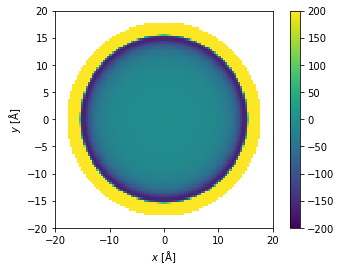

In [684]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
im = ax.imshow(Vfit2.T,origin='lower',vmax=200,vmin=-200,extent=(-20,20,-20,20))
circ = Circle((.2,0),12,alpha=.5)
#ax.add_patch(circ)
plt.colorbar(im)
ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
fig.savefig('plots/Vfit1.svg',bbox_inches='tight')

In [612]:
np.nanmin(VmeshUnsorted)

-648.1552567795754

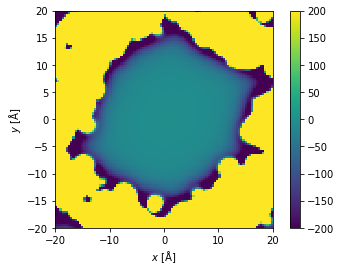

In [660]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
im = ax.imshow(VmeshUnsorted.T,origin='lower',vmax=200,vmin=-200,extent=(-20,20,-20,20))
plt.colorbar(im)
ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
fig.savefig('plots/Vmb.svg',bbox_inches='tight')

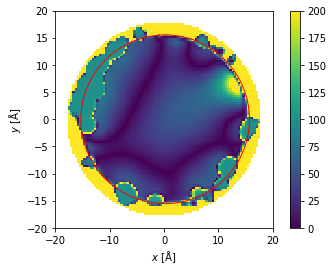

In [685]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
im = ax.imshow(100*np.abs((VmeshUnsorted.T-Vfit2.T)/VmeshUnsorted.T),origin='lower',vmax=200,vmin=0,extent=(-20,20,-20,20))
ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')

plt.colorbar(im)

circ = Circle((.2,0),pore_radius,facecolor='None',edgecolor='r')
ax.add_patch(circ)
fig.savefig('plots/Vfit1percentdiff.svg',bbox_inches='tight')

In [312]:
Verr = np.abs((Vfit-Vmesh)/Vmesh)

Text(0,0.5,'$|\\frac{V_\\mathrm{fit}-V}{V}|$ $\\mathrm{[K]}$')

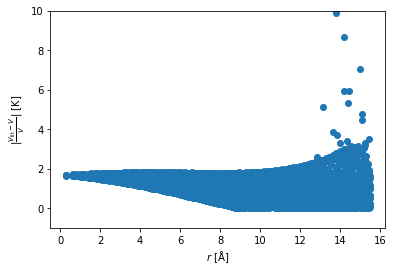

In [389]:
plt.scatter(rmesh[rmesh<rcut],Verr[rmesh<rcut],)
plt.ylim(-1,10)
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'$|\frac{V_\mathrm{fit}-V}{V}|$ $\mathrm{[K]}$')


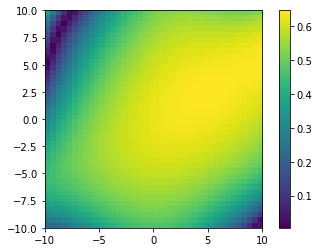

In [391]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
im = ax.imshow(np.abs((VmeshUnsorted.T-Vfit2.T)/Vfit2.T)[30:70,30:70],origin='lower',extent=(-10,10,-10,10))
plt.colorbar(im)
#circ = Circle((.2,0),12,alpha=.5)
#ax.add_patch(circ)

In [686]:
rcut = 14
fitparams = []
fiterr = []
for i, c in enumerate(rhoarr):
    cind = c < rcut
    xdata = c[cind]
    ydata = varr[i][cind]

    fitind = (ydata < 0.0)

    popt, pcov = curve_fit(U_min2, xdata[fitind], ydata[fitind],[3.44, 1.59],maxfev=10000)

    perr = np.sqrt(np.diag(pcov))
    fitparams.append(popt)
    fiterr.append(perr)
fitparams=np.array(fitparams)
fiterr=np.array(fiterr)

72
65
62
60
59
58
57
55
54


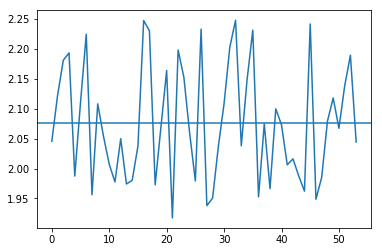

In [687]:
fitSigma = fitparams[:,0]
avgSigma = np.average(fitSigma)
errSigma = np.std(fitSigma)
minSigma = fitSigma >= (avgSigma - (2*errSigma))
maxSigma = fitSigma <= (avgSigma + (2*errSigma))
indSigma = minSigma*maxSigma
newAvgSigma = np.average(fitSigma[indSigma])
print(len(fitSigma))
while True:  
    print(len(fitSigma[indSigma]))
    avgSigma = newAvgSigma
    errSigma = np.std(fitSigma[indSigma])
    minSigma = fitSigma >= (avgSigma - (2*errSigma))
    maxSigma = fitSigma <= (avgSigma + (2*errSigma))
    indSigma = minSigma*maxSigma
    newAvgSigma = np.average(fitSigma[indSigma])
    if newAvgSigma == avgSigma:
        break
errSigma=errSigma/np.sqrt(len(fitSigma[indSigma]))
plt.plot(fitSigma[indSigma])
plt.axhline(avgSigma)

72
68
67


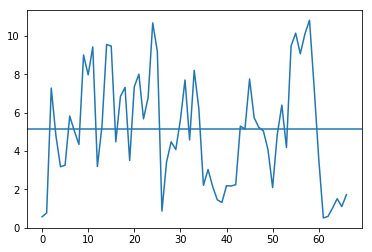

In [688]:
fitnEpsilon = fitparams[:,1]
avgnEpsilon = np.average(fitnEpsilon)
errnEpsilon = np.std(fitnEpsilon)
minnEpsilon = fitnEpsilon >= (avgnEpsilon - (2*errnEpsilon))
maxnEpsilon = fitnEpsilon <= (avgnEpsilon + (2*errnEpsilon))
indnEpsilon = minnEpsilon*maxnEpsilon
newAvgnEpsilon = np.average(fitnEpsilon[indnEpsilon])
print(len(fitnEpsilon))
while True:  
    print(len(fitnEpsilon[indnEpsilon]))
    avgnEpsilon = newAvgnEpsilon
    errnEpsilon = np.std(fitnEpsilon[indnEpsilon])
    minnEpsilon = fitnEpsilon >= (avgnEpsilon - (2*errnEpsilon))
    maxnEpsilon = fitnEpsilon <= (avgnEpsilon + (2*errnEpsilon))
    indnEpsilon = minnEpsilon*maxnEpsilon
    newAvgnEpsilon = np.average(fitnEpsilon[indnEpsilon])
    if newAvgnEpsilon == avgnEpsilon:
        break
errnEpsilon=errnEpsilon/np.sqrt(len(fitnEpsilon[indnEpsilon]))
plt.plot(fitnEpsilon[indnEpsilon])
plt.axhline(avgnEpsilon)

In [690]:
errSigma

0.013172487933625746

In [691]:
errnEpsilon

0.3566899632075134

In [624]:
print('$\sigma={:.3f}\mathrm{{Å}}$, $n\epsilon = {:.3f}\mathrm{{KÅ^{{-2}}}}$, and $R={:.3f}\mathrm{{Å}}$'.format(avgSigma,avgnEpsilon,avgR))

$\sigma=2.076\mathrm{Å}$, $n\epsilon = 5.130\mathrm{KÅ^{-2}}$, and $R=17.942\mathrm{Å}$


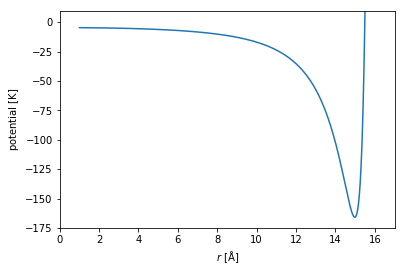

In [720]:
#plt.scatter(rmesh[rmesh<pore_radius],Vmesh[rmesh<pore_radius])
#plt.plot(rmesh,U_min2(rmesh,avgSigma,avgnEpsilon),color='r')
rfinal = np.linspace(1,17,1000)
vfinal = U_min(rfinal,3.44,1.59,17.94)
plt.plot(rfinal,vfinal)
plt.ylim(-175,10)
plt.xlim(0,17)
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'$\mathrm{potential}$ $\mathrm{[K]}$')
plt.savefig('plots/effectivePotentialMCM-41.svg',bbox_inches='tight')

In [711]:
rfinal[np.argmin(vfinal)]

14.981981981981981

In [692]:
Vfit = U_min2(rmesh,avgSigma,avgnEpsilon)

In [693]:
Vfit2 = np.reshape(Vfit[rmeshaa],(int(abs(res)),int(abs(res))))

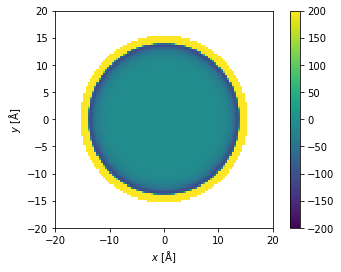

In [694]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
im = ax.imshow(Vfit2.T,origin='lower',vmax=200,vmin=-200,extent=(-20,20,-20,20))
circ = Circle((.2,0),12,alpha=.5)
#ax.add_patch(circ)
plt.colorbar(im)
ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
fig.savefig('plots/Vfit2.svg',bbox_inches='tight')

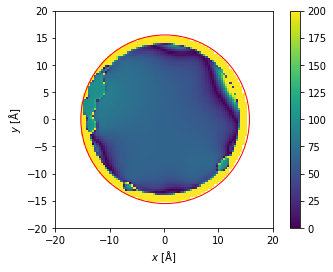

In [695]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
im = ax.imshow(100*np.abs((VmeshUnsorted.T-Vfit2.T)/VmeshUnsorted.T),origin='lower',vmax=200,vmin=0,extent=(-20,20,-20,20))
ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')

plt.colorbar(im)

circ = Circle((.2,0),pore_radius,facecolor='None',edgecolor='r')
ax.add_patch(circ)

fig.savefig('plots/Vfit2percentdiff.svg',bbox_inches='tight')

In [631]:
Verr = np.abs((Vfit-Vmesh)/Vmesh)

Text(0,0.5,'$|\\frac{V_\\mathrm{fit}-V}{V}|$ $\\mathrm{[K]}$')

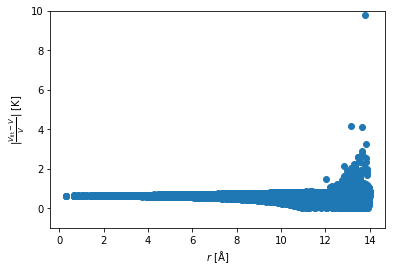

In [632]:
plt.scatter(rmesh[rmesh<rcut],Verr[rmesh<rcut],)
plt.ylim(-1,10)
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'$|\frac{V_\mathrm{fit}-V}{V}|$ $\mathrm{[K]}$')


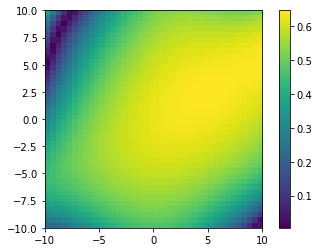

In [391]:
from matplotlib.patches import Circle
fig,ax = plt.subplots()
im = ax.imshow(np.abs((VmeshUnsorted.T-Vfit2.T)/Vfit2.T)[30:70,30:70],origin='lower',extent=(-10,10,-10,10))
plt.colorbar(im)
#circ = Circle((.2,0),12,alpha=.5)
#ax.add_patch(circ)

### Shell of argon ###

In [15]:
# Argon density
SA = 915.0*1e20 #surface area \AA^2/g
MLC = 8.994e-3 #monolayer argon coverage mol/g
n_2d = 6.022140857e23*MLC/SA #argon atoms per \AA^2
n_3d = n_2d/3.5
n_3dArPaulWiki = n_3d




# Neon Density
argonMass = 39.948 #g/mole
argonRadius = 188e-12 #m
NA = 6.022140758e23 #atoms/mole
L_to_m3 = 0.001 #m^3/L

argonDensitySolid = 1616 #g/L
n_3dArFromSolidDensity = (((argonDensitySolid/L_to_m3)/argonMass)*NA*((1e-10)**3)) #atoms/m^3

argonDensityLiquid = 1395.4 #g/L
n_3dArFromLiquidDensity = (((argonDensityLiquid/L_to_m3)/argonMass)*NA*((1e-10)**3)) #atoms/m^3

argonDensityArr = [n_3dArPaulWiki,n_3dArFromSolidDensity,n_3dArFromLiquidDensity]

print(r'{:.3f}$\mathrm{{Å}}^{{-3}}$'.format(n_3d))

0.017$\mathrm{Å}^{-3}$


In [16]:
# sigma and epsilon parameters for atoms in silica and helium
# See https://doi.org/10.1016/j.apsusc.2015.01.084 and https://doi.org/10.1016/S0927-7757(01)00628-8
sigmaarr = np.array([(3.804,3.033,2.846,2.640,3.405,2.782)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])
epsilonarr = np.array([(155.858,48.115,0.0503,10.9,119.8,37.29134539)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])

# functions to mix the LJ parameters
# See https://doi.org/10.1016/S0927-7757(01)00628-8
def mixsigma(s1,s2):
    return (s1+s2)/2.0

def mixepsilon(e1,e2):
    return (e1*e2)**0.5

In [17]:
sArHe = mixsigma(sigmaarr['He'],sigmaarr['Ar'])
eArHe = mixepsilon(epsilonarr['He'],epsilonarr['Ar'])
print(sArHe)
print(eArHe)

[3.0225]
[36.13613]


In [18]:
rtest = np.linspace(0,16,1000)

In [40]:
V_ArArr = []
for n_3dAr in argonDensityArr:
    V_Ar = Vshell(rtest,sArHe,eArHe*n_3dAr,pore_radius-(1.88*2),pore_radius)
    V_ArArr.append(V_Ar)

In [41]:
V_Ar=V_ArArr[0]

In [42]:
15.51-3.76

11.75

In [43]:
V_MCM41 = V(rtest,3.44,1.59,pore_radius)

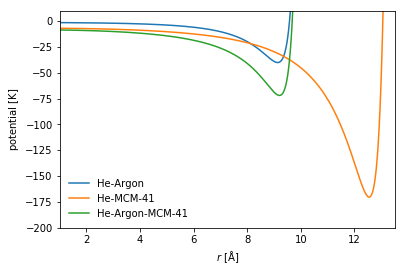

In [44]:
plt.plot(rtest,V_Ar,label='He-Argon')
plt.plot(rtest,V_MCM41,label='He-MCM-41')
plt.plot(rtest,V_Ar+V_MCM41,label='He-Argon-MCM-41')
plt.ylim(-200,10)
plt.xlim(1,13.5)
plt.xlabel(r'$r$ $\mathrm{[\AA]}$')
plt.ylabel(r'$\mathrm{potential}$ $\mathrm{[K]}$')
plt.legend(frameon=False)
plt.savefig('plots/Vcombined.svg',bbox_inches='tight')

In [45]:
1.88 #Argon radius
1.54 #Neon Radius

1.54

In [46]:
15.51-(1.54*2)

12.43

In [47]:
# Neon Density
neonMass = 20.1797 #g/mole
neonRadius = 154e-12 #m
NA = 6.022140758e23 #atoms/mole
L_to_m3 = 0.001 #m^3/L

neonDensitySolid = 1444 #g/L
n_3dNeFromSolidDensity = (((neonDensitySolid/L_to_m3)/neonMass)*NA*((1e-10)**3)) #atoms/m^3

neonDensityLiquid = 1207 #g/L
n_3dNeFromLiquidDensity = (((neonDensityLiquid/L_to_m3)/neonMass)*NA*((1e-10)**3)) #atoms/m^3

n_3dNeArgonLayerDensity = n_2d/1.52/2

n_3dNeFromOldSokolPaper = 1/(3*np.sqrt(3)*3.13*3.13*3.04/2)


In [48]:
neonDensityArr = [n_3dNeFromSolidDensity,n_3dNeFromLiquidDensity,n_3dNeArgonLayerDensity,n_3dNeFromOldSokolPaper]

In [49]:
sNeHe = mixsigma(sigmaarr['He'],sigmaarr['Ne'])
eNeHe = mixepsilon(epsilonarr['He'],epsilonarr['Ne'])

In [50]:
sNeHe = mixsigma(sigmaarr['He'],sigmaarr['Ne'])
eNeHe = mixepsilon(epsilonarr['He'],epsilonarr['Ne'])
print(sNeHe)
print(eNeHe)

[2.711]
[20.161242]


In [51]:
V_NeArr = []
for n_3dNe in neonDensityArr:
    V_Ne = Vshell(rtest,sNeHe,eNeHe*n_3dNe,pore_radius-(1.54*2),pore_radius)
    V_NeArr.append(V_Ne)

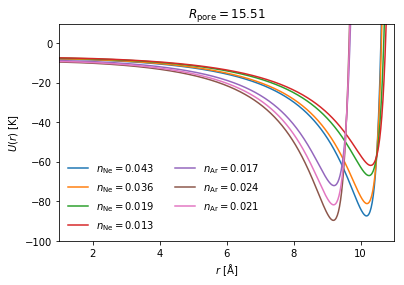

In [52]:
fig,ax = plt.subplots()
for i,V_Ne in enumerate(V_NeArr):
    ax.plot(rtest,V_Ne+V_MCM41,label='$n_\mathrm{{Ne}}={:2.3f}$'.format(neonDensityArr[i]))

for i,V_Ar in enumerate(V_ArArr):
    ax.plot(rtest,V_Ar+V_MCM41,label='$n_\mathrm{{Ar}}={:2.3f}$'.format(argonDensityArr[i]))
ax.set_ylim((-100,10))
ax.set_xlim((1,11))
ax.set_xlabel(r'$r$ $\mathrm{[\AA]}$')
ax.set_ylabel(r'$U(r)$ $\mathrm{[K]}$')
ax.set_title(r'$R_\mathrm{{pore}}={}$'.format(pore_radius))
ax.legend(frameon=False,ncol=2)
fig.savefig('plots/HeliumonArgonorNeonandMCM41VariousDensities_r{:2.2f}.svg'.format(pore_radius),bbox_inches='tight')
fig.savefig('plots/HeliumonArgonorNeonandMCM41VariousDensities_r{:2.2f}.png'.format(pore_radius),bbox_inches='tight',dpi=400)

In [30]:
print(argonDensityArr)
print(neonDensityArr)

[0.016912766547340516, 0.02436111811587063, 0.021035584293865026]
[0.043092668644984816, 0.036019979954637585, 0.01947193516963546, 0.01292366984842918]


#### PIMC Script ####

In [1145]:
import numpy as np
import time
params = {
         'param_file':['./mcm-41.xml']
         }
density = np.linspace(0,1,500)
dups=2
fout = open('mcm-41a-%d.sh' % int(time.time()*1000),'w')
timeStart = int(time.time()*1000)
for n in density:
    for j in range(dups):
        dTime = int(time.time()*1000) - timeStart 
        fout.write('pimc.e -n {} --param_file mcm-41a.xml -p {}\n'.format(n,10000*dTime))
        time.sleep(1e-3)
fout.close()

### Summation in Reciprical Space ###

In [768]:
def U_6dir():
    t1 = (B_i*B_j/(d_ij**6))*np.exp(-((beta*d_ij)**2))*(1.0+((beta*d_ij)**2)+(0.5*((beta*d_ij)**4)))
    return 0.5*t1

def U_6rec():
    pf = (np.pi**(9/2))/(3*V)
    x = np.pi*np.linalg.norm(eta)/beta
    t1 = (np.linalg.norm(eta)**3)*(((1.0/(2.0*((x)**3)))*(1.0-(2.0*(x**2)))*np.exp(-(x**2)))+(np.sqrt(np.pi)*erfc(x)))*Sf(eta)*Sf(-eta)
    return pf*t1



662

In [1098]:
from scipy.special import erfc
def U_12(r,sigma,epsilon):
    return 4*epsilon*((sigma/r)**12)

def U_6(r,sigma,epsilon):
    return 4*epsilon*((sigma/r)**6)

def f(x):
    return (1.0/3.0)*(((1.0-(2.0*(x**2)))*np.exp(-(x**2))+(2.0*(x**3)*np.sqrt(np.pi)*erfc(x))))

def g(x):
    return np.exp(-(x**2))*(1.0+(x**2)+((x**4)/2.0))

def Z_a(a,r,m,sigma):
    return (sigma**a)*np.exp(2.0*np.pi*1j*np.dot(r,m))

PT = [1,6,15,20,15,6,1]

def U_6direct(r,r_uc,n_lattice,sigma,epsilon,beta):
    V=0.0
    for n in n_lattice:
        x = np.linalg.norm(r_uc-r+n,axis=-1)
        V+=np.sum(sigma*epsilon*g(beta*x)/(x**6)/16)
    return V

def U_6recip(r,r_uc,m_reciplattice,sigma,sigma_uc,epsilon_uc,beta,volume):
    pf = (np.pi**(3/2))*(beta**3)/volume
    V=0.0
    for m in m_reciplattice:
        x = f(np.pi*np.linalg.norm(m)/beta)
        zz=0.0
        for i in range(7):
            zz += np.sum(PT[i]*Z_a(i,r,m,sigma)*Z_a(i,r_uc,-m,sigma_uc)*epsilon_uc/16)
        V+=x*zz
    return pf*V

In [1099]:
a1 = cell_length_a*np.array([.5,-np.sqrt(3)/2,0])
a2 = cell_length_b*np.array([.5,+np.sqrt(3)/2,0])
a3 = cell_length_c*np.array([0,0,1])

In [1100]:
b1 = 2*np.pi*np.cross(a2,a3)/(np.dot(a1,np.cross(a2,a3)))
b2 = 2*np.pi*np.cross(a3,a1)/(np.dot(a2,np.cross(a3,a1)))
b3 = 2*np.pi*np.cross(a1,a2)/(np.dot(a3,np.cross(a1,a2)))

In [1101]:
cell_volume=np.dot(np.cross(a1,a2),a3)

In [1102]:
r_uc = np.zeros((len(mcm_41xyz),3))

In [1103]:
r_uc[:,0]=mcm_41xyz_shifted[:,0]-np.dot(B,side/2.0)[0]
r_uc[:,1]=mcm_41xyz_shifted[:,1]-np.dot(B,side/2.0)[1]
r_uc[:,2]=mcm_41xyz['z']-(cell_length_c/2)

In [1104]:
sigma_uc = np.zeros(len(r_uc))
sigma_uc_unmixed = np.zeros(len(r_uc))
epsilon_uc = np.zeros(len(r_uc))
for n in sigmaarr.dtype.names:
    n_byte = str.encode(n)
    sigma_uc[mcm_41xyz['type_symbol']==n_byte] = mixsigma(sigmaarr[n],sigmaarr['He'])
    sigma_uc_unmixed[mcm_41xyz['type_symbol']==n_byte] = sigmaarr[n]
    epsilon_uc[mcm_41xyz['type_symbol']==n_byte] = mixepsilon(epsilonarr[n],epsilonarr['He'])

In [1128]:
n_lattice = []
imax=41
jmax=41
kmax=41
for i in range(imax):
    for j in range(jmax):
        for k in range(kmax):
            vec = (a1*(i-((imax-1)//2))) + (a2*(j-((jmax-1)//2))) + (a3*(k-((kmax-1)//2)))
            n_lattice.append(vec)
n_lattice = np.array(n_lattice)

In [1106]:
n_lattice=n_lattice[np.argsort(np.linalg.norm(n_lattice,axis=-1))]

In [1119]:
m_reciplattice = []
imax=41
jmax=41
kmax=41
for i in range(imax):
    for j in range(jmax):
        for k in range(kmax):
            vec = (b1*(i-((imax-1)//2))) + (b2*(j-((jmax-1)//2))) + (b3*(k-((kmax-1)//2)))
            m_reciplattice.append(vec)
m_reciplattice = np.array(m_reciplattice)

In [1120]:
m_reciplattice=m_reciplattice[np.argsort(np.linalg.norm(m_reciplattice,axis=-1))]

In [1121]:
beta=.0000001
r = np.array([0,0,0])
test1 = U_6direct(r,r_uc,n_lattice[:20],sigma_uc,epsilon_uc,100)


In [1122]:
test2 = U_6recip(r,r_uc,m_reciplattice,sigmaarr['He'],sigma_uc_unmixed,epsilon_uc,beta,cell_volume)

In [1129]:
test3 = 0.0
for n in n_lattice:
    sep = np.linalg.norm(r_uc-r+n,axis=-1)
    test3 += np.sum(U_12(sep,sigma_uc,epsilon_uc))

In [1130]:
test4 = 0.0
for n in n_lattice:
    sep = np.linalg.norm(r_uc-r+n,axis=-1)
    test4 += np.sum(U_6(sep,sigma_uc,epsilon_uc))

In [1131]:
len(n_lattice)

68921

In [1137]:
test1

0.0

In [1132]:
test3 - test2 - test1

(3.963892331086221e-05+0j)

In [1133]:
test3-test4

-3.01280766435741

In [1113]:
test3 - test2 - test1

(3.9638923277025575e-05+0j)

In [1114]:
test3-test4

-3.0116625038166935

In [918]:

V=0.0
for n in n_lattice:
    x = np.linalg.norm(r_uc-r+n,axis=-1)
    V+=np.sum(sigma_uc*epsilon_uc*g(beta*x)/(x**6)/16)
print(V)

0.5340898992597172


In [952]:
test2

(3160587.0552877486+4.640130053468393e-12j)

In [782]:
len(np.linalg.norm(np.fft.fftn(mcm_41xyz_shifted),axis=1))

662

In [374]:
9.494*7.69*6.022

439.65935492

In [537]:
from scipy.spatial.distance import cdist
sep = cdist(rmeshpoints, stackedcutpoints, 'euclidean')

In [ ]:
ddd = rmeshpoints[np.argsort(np.linalg.norm(rmeshpoints,axis=-1))][0:10]

In [ ]:
ppp = np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T

In [485]:
V_ddd = np.zeros_like(ddd)

In [486]:
for i, r_ddd in enumerate(ddd):
    V_ddd[i] += U_mb(r_ddd,cutpoints,cutsigma,cutepsilon)

In [487]:
V_ddd

array([[-1.3777318 , -1.3777318 , -1.3777318 ],
       [-1.37552667, -1.37552667, -1.37552667],
       [-1.39776993, -1.39776993, -1.39776993],
       [-1.39343381, -1.39343381, -1.39343381],
       [-1.42188919, -1.42188919, -1.42188919],
       [-1.38344657, -1.38344657, -1.38344657],
       [-1.42849374, -1.42849374, -1.42849374],
       [-1.39004028, -1.39004028, -1.39004028],
       [-1.3993094 , -1.3993094 , -1.3993094 ],
       [-1.41231108, -1.41231108, -1.41231108]])

In [488]:
V_ddd2=U_mb2(ddd,cutpoints,cutsigma,cutepsilon)

ValueError: operands could not be broadcast together with shapes (363550,) (3,) 

In [492]:
ddd[:,0]

array([ 0.2020202 ,  0.2020202 , -0.2020202 , -0.2020202 , -0.60606061,
        0.2020202 , -0.60606061,  0.2020202 , -0.2020202 , -0.2020202 ])

In [498]:
ppp = np.array((cutpoints['x'],cutpoints['y'],cutpoints['z'])).T

In [523]:
from scipy.spatial.distance import cdist
eee = cdist(ddd, ppp, 'euclidean')

In [532]:
U_mb2(eee,cutsigma,cutepsilon)

array([-1.37773194, -1.37552671, -1.39777026, -1.39343395, -1.42188928,
       -1.38344667, -1.42849392, -1.39004025, -1.3993094 , -1.41231108])

In [524]:
fff = [U(eee[i],cutsigma,cutepsilon) for i in range(len(eee))]

In [526]:
np.all(np.array(fff)==U(eee,cutsigma,cutepsilon))

True

In [530]:
np.sum(U(eee,cutsigma,cutepsilon),1)

array([-1.37773194, -1.37552671, -1.39777026, -1.39343395, -1.42188928,
       -1.38344667, -1.42849392, -1.39004025, -1.3993094 , -1.41231108])

In [460]:
import datetime
meshsize = int(abs(res*res))
timearr = []
for i in range(int(abs(res))):
    for j in range(int(abs(res))):
        step = (i*int(abs(res))+j)
        for ii in range(150):
            timeold = time.time()
            time.sleep(1)
            estleft = (150-ii)+((meshsize-step)*150)
            timenew = time.time()
            timearr.append(timenew-timeold)
            timeleft = str(datetime.timedelta(seconds=np.average(timearr)*estleft))
            print('Step {} of {}. Estimated time remaining = {}. {:.5f}% complete: z-loop progress {:.3f}%'.format(step, meshsize, timeleft, 100*step/meshsize, 100*ii/150), end='\r')

KeyboardInterrupt: 

In [ ]:
res = 100j
rxmesh,rymesh = np.mgrid[-20:20:res,-20:20:res]
meshsize = int(abs(res*res))
Vmesh = np.zeros_like(rxmesh,dtype=np.float32)
for i in range(int(abs(res))):
    for j in range(int(abs(res))):
        rx = rxmesh[i,j]
        ry = rymesh[i,j]
        rz = 0.0
        Vmesh[i,j] += U_mb(np.array([rx,ry,rz]),cutpoints,cutsigma,cutepsilon)

timearr = []
for i in range(int(abs(res))):
    for j in range(int(abs(res))):
        step = (i*int(abs(res))+j)
        Vnew = np.copy(Vmesh[i,j])
        rx = rxmesh[i,j]
        ry = rymesh[i,j]
        
        for ii in range(150):
            timeold = ???
            rz = ((ii+1)*cell_length_c)
            Vmesh[i,j]+=U_mb(np.array([rx,ry,rz]),cutpoints,cutsigma,cutepsilon)
            rz = -((ii+1)*cell_length_c)
            Vmesh[i,j]+=U_mb(np.array([rx,ry,rz]),cutpoints,cutsigma,cutepsilon)
            Vold = np.copy(Vnew)
            Vnew = np.copy(Vmesh[i,j])
            estleft = (150-ii)+(meshsize-step)
            timenew = ???
            timearr.append(timenew-timeold)
            timeleft = np.average(timearr)*estleft
            print('Step {} of {}. Estimated time remaining = {}. {:.5f}% complete: z-loop progress {:.3f}%'.format(step, meshsize, timeleft, 100*step/meshsize, 100*ii/150), end='\r')
            if Vold==Vnew:
                break

In [221]:
def stackRecArray(arr,j=50):
    tmp = np.copy(arr)
    for i in range(j):
        tmp2 = np.copy(tmp)
        tmp2['z'] += (i+1)*cell_length_c
        arr = np.append(arr,tmp2)
        tmp2 = np.copy(tmp)
        tmp2['z'] -= (i+1)*cell_length_c
        arr = np.append(arr,tmp2)
    return arr

def stackRecArray2(arr,j=50):
    tmp = np.copy(arr)
    for i in range(j):
        tmp2 = np.copy(tmp)
        arr = np.append(arr,tmp2)
        tmp2 = np.copy(tmp)
        arr = np.append(arr,tmp2)
    return arr

In [222]:
zpoints = stackRecArray(zpoints)
zsigma =  stackRecArray2(zsigma)
zepsilon =  stackRecArray2(zepsilon)

In [ ]:
sortind = np.argsort(np.abs(zpoints['z']))
zsigma = zsigma[sortind]
zepsilon = zepsilon[sortind]
zpoints = zpoints[sortind]

In [224]:
print(np.max(zpoints['z']))

739.67584


In [ ]:
V_z = []
for r_test in np.vstack((x,y,y)).T:
    V_z.append(U_mb(r_test,zpoints,zsigma,zepsilon))

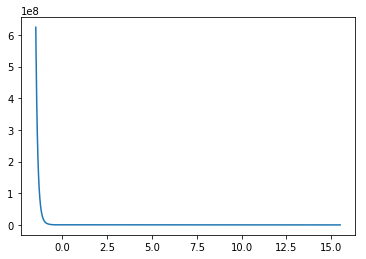

In [232]:
plt.plot(pore_radius - x,V_z)

In [ ]:
z_cut=15
cutzpoints = zpoints[r < r_cut]
cutzsigma = zsigma[r < r_cut]
cutzepsilon = zepsilon[r < r_cut]
V_zcut = []
for r_test in np.vstack((x,y,y)).T:
    V_zcut.append(U_mb(r_test,cutpoints,cutsigma,cutepsilon))

In [178]:
np.array((0,0,2,b''),dtype=asdf.dtype)

array((0., 0., 2., b''),
      dtype=(numpy.record, [('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('atom', 'S2')]))

In [180]:
asdf[0] + (0,0,2,b'')

TypeError: invalid type promotion

In [173]:
asdf[0]

(-184.99097, -149.20045, -0.00139284, b'H')

In [170]:
cutpoints['z'][0]

-0.0013928413

In [ ]:
for i in range(5):
    np.append(cutpoints,)

In [156]:
np.min(cutpoints['z']) + cell_length_c

4.084379720581055

In [159]:
print(len(cutpoints['z']))
print(len(points))

363558
4343382


In [410]:
xxx = []
for i in range(5):
    xxx.append(np.arange(10))

In [411]:
np.shape(xxx)

(5, 10)

In [470]:
yyy = (np.reshape(np.array(xxx),(50))-5)

In [471]:
zzz= np.array(10*['A','B','C','D','E'])

In [473]:
records = np.rec.fromarrays((yyy,yyy*2,yyy*3,zzz), names=('x', 'y', 'z', 'atom'))

In [498]:
rtest = np.sqrt((records['x']**2) + (records['y']**2))

In [501]:
records

rec.array([(-5, -10, -15, 'A'), (-4,  -8, -12, 'B'), (-3,  -6,  -9, 'C'),
           (-2,  -4,  -6, 'D'), (-1,  -2,  -3, 'E'), ( 0,   0,   0, 'A'),
           ( 1,   2,   3, 'B'), ( 2,   4,   6, 'C'), ( 3,   6,   9, 'D'),
           ( 4,   8,  12, 'E'), (-5, -10, -15, 'A'), (-4,  -8, -12, 'B'),
           (-3,  -6,  -9, 'C'), (-2,  -4,  -6, 'D'), (-1,  -2,  -3, 'E'),
           ( 0,   0,   0, 'A'), ( 1,   2,   3, 'B'), ( 2,   4,   6, 'C'),
           ( 3,   6,   9, 'D'), ( 4,   8,  12, 'E'), (-5, -10, -15, 'A'),
           (-4,  -8, -12, 'B'), (-3,  -6,  -9, 'C'), (-2,  -4,  -6, 'D'),
           (-1,  -2,  -3, 'E'), ( 0,   0,   0, 'A'), ( 1,   2,   3, 'B'),
           ( 2,   4,   6, 'C'), ( 3,   6,   9, 'D'), ( 4,   8,  12, 'E'),
           (-5, -10, -15, 'A'), (-4,  -8, -12, 'B'), (-3,  -6,  -9, 'C'),
           (-2,  -4,  -6, 'D'), (-1,  -2,  -3, 'E'), ( 0,   0,   0, 'A'),
           ( 1,   2,   3, 'B'), ( 2,   4,   6, 'C'), ( 3,   6,   9, 'D'),
           ( 4,   8,  12, 'E'), (-5, -

In [487]:
def fields_view(array, fields):
    return array.getfield(np.dtype(
        {name: array.dtype.fields[name] for name in fields}
    ))

In [488]:
v1 = fields_view(records, ["x", "y"])

In [493]:
v2 = records[['x','y']]

/usr/local/lib/python3.6/dist-packages/numpy/core/records.py:513: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


In [496]:
np.linalg.norm(v2.copy())

ValueError: Can't cast from structure to non-structure, except if the structure only has a single field.